# Homework 3: 

# Theory 
## Questions 
- Why apply a logarithm on the likelihood?
    - it simplifies calculations and does not change the result. More about it in answers below
- What are analytical reasons?
    - instead of product of probabilities, we get the sum of logarithms. Because of this, calculating derivative in order to get maximum likelihood estimation is being simplified a lot, e.g. we get rid exponent in Gaussian distribution.
- What are numerical reasons?
    - applying a logarithm to the likelihood can help avoiding numerical instability. The likelihood function often involves multiplying a large number of probabilities together, which can result in very small or very large values.
- Does it affect the estimator?
    - it does not affect estimator, the estimated parameters are the same.

## Task 1
We observe an experiment $D=\{x_1,\cdots, x_n\}$ with i.i.d. $x_i \sim p(x_i|\mu,\sigma^2) = \dfrac{1}{\sqrt{2\pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$.
What is the MLE for $\mu$ and $\sigma^2$ ?

## Task 2
We observe am experiment $D=\{(x_1,y_1),\cdots, (x_n,y_n)\}$. We assume a linear model with Gaussian noise: $y_i = x_i\cdot a + b + \epsilon_i$  with i.i.d. $\epsilon_i \sim \mathcal{N}(0,\sigma^2)$.
       What is the MLE for $a,b$ and $\sigma^2$ ?

## Task 3
Assume we have a Bernoulli process, where we toss a coin multiple times.  
Let $D = (x_1, x_2, . . . , x_7) = (0, 0, 1, 1, 0, 0, 1)$ be the measurements. 
Assume $p(x_i|\theta)=
\begin{cases}
\theta  & \text{if} ~ x_i=1 ~ (head),\\
1-\theta ~ &\text{if} ~ x_i=0 ~ (tail)
\end{cases}$

- Let $p(\theta)=\mathcal{N}(0.5,0.1)$. What is the MAP estimator $\theta_{MAP}$? What is the probability of tossing tails two times $P(x_8=0, x_9=0|\theta_{MAP})$
- Let $p(\theta)=\mathcal{U}(0,1)$. What is the probability of the next toss to be head $P(x_8=1|D)$ 


# Praxis

The goal of the exercise is to implement a Maximum Likelihood Estimator for a normal distribution.  
We create $n$ data samples from a 2D normal distribution $X_i \sim \mathcal{N}(\mu, \Sigma)$

We would like to estimate the mean $mu$ using a numerical appraoch with gradient ascent.

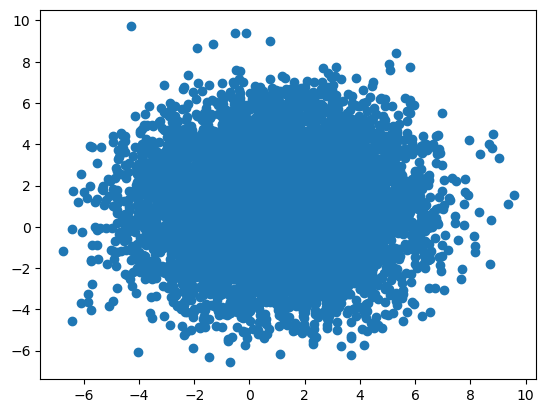

In [2]:
import numpy as np 
import torch
import matplotlib.pyplot as plt

n = 10000 # number of samples (descrease the number if computations take too much time)
mu, sigma = np.ones(2), 5*np.eye(2) # mean and standard deviation of ground truth distribution
data = np.random.multivariate_normal(mu, sigma, n) # sample n data points from the distribution
plt.scatter(data[:,0],data[:,1])
plt.show()


# Maximum Likelihood

The likelihood of a single data point is given as:  
$$p(x; \mu, \Sigma) = \dfrac{1}{\sqrt{|\Sigma|(2\pi)^2}} 
  \exp\left( -\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T \right)$$

The log-likelihood is:
$$\log (p(x; \mu, \Sigma)) =-\frac{1}{2}(x-\mu)\Sigma^{-1}(x-\mu)^T  + C $$

The joint likelihood over the whole data is:  
$$p(D;\mu, \Sigma) = \prod_i^n p(x_i; \mu, \Sigma)$$

We would like to find $\mu$ that has the highest likelihood for the given data. We assume for now, that $\Sigma$ is known:
$$ \max_\mu  p(D;\mu, \Sigma) $$
This is equivalent to maximizing the log-likelihood:
$$\Leftrightarrow  \max_\mu L(\mu) := \log (p(D;\mu, \Sigma))$$ 

Since $L(\mu)$ is a differentiable function, we can try to find the maximum using gradient ascent to find the local maximum.  
We can utilize Pytorch automatic differentiation to compute the gradients for us.  

Given are two heper functions:
1. the log-likelihood $L(\mu)$ for a given dataset
2. a visualization of the log-likelihood over a range $[-5,5]\times [-5,5]$ as a heatmap.

In [3]:
def L(X, mu, sigma):
    """ 
    Computes the log-likelihood over a dataset X for an estimated normal distribution parametrized 
    by mean mu and covariance sigma

    X : Tensor 
        A data matrix of size n x 2 
    mu: Tensor of size 2
        a tensor with two entries describing the mean
    sigma: Tensor of size 2x2
        covariance matrix
    """
    diff = X-mu
    z = -0.5*diff@sigma.inverse()*diff
    return z.sum()

def vizualize(X, mus, sigma):
    """ 
    Plots a heatmap of a likelihood evaluated for different mu.
    It also plots a list of gradient updates. 

    X : Tensor 
        A data matrix of size n x 2 
    mus: list[Tensor]  
        A list of 2D tensors. The tensors should be detached from and on CPU.
    sigma: Tensor of size 2x2
        covariance matrix
    """
    loss = lambda x,y: L(X,torch.tensor([x,y]),sigma)
    loss = np.vectorize(loss)
    space = np.linspace(-5,5,100)
    x,y  = np.meshgrid(space,space)
    zs = np.array(loss(np.ravel(x), np.ravel(y)))
    z = zs.reshape(x.shape)
    plt.pcolormesh(x,y, z )

    mu_x, mu_y = zip(*mus)
    plt.plot(mu_x, mu_y)
    plt.xlim([-5,5])
    plt.ylim([-5,5])
    plt.show()


### Example Use of functions:

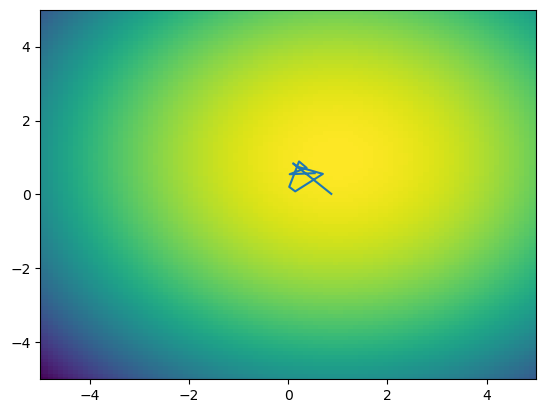

In [4]:
mu = torch.tensor([0.0,0.0],dtype=torch.float64, requires_grad=True) # 2D vector
sigma =  torch.tensor(sigma,dtype=torch.float64) # 2D convariance matrix
X = torch.tensor(data,dtype=torch.float64)  # data samples as tensor

loss = L(X,mu, sigma)  # computing loss
loss.backward()  # backpropagation
mu.grad  # gradients are stored in the object


mus = [torch.rand(2) for _ in range(10)] # a list 2D mu updates (dont)
vizualize(X,mus,sigma) 

## Task 1 : MLE using gradient ascent

Find the maximum by computing gradient ascent:
$$ \mu_{t+1} = \mu_{t} + \lambda \dfrac{d}{d \mu}L(\mu) $$

1. Implement a function that does the following steps:
    - initialize $\mu_0 = (0,0)^T$
    - compute Likelihood $L(\mu)$ 
    - calculate gradient $\dfrac{d}{d \mu}L(\mu) $ using Pytorch's automatic differentiation
    - update $\mu$
    - repeat until convergence or after certain amount of steps 
2. Visualize your gradient updates
3. How does the learning rate $\lambda$ affect convergence?

## Task 2: Better Gradient Updates

1. Change your vanilla gradient updates to a more sophisticated approach.  You can use any of Pytorch's optimization methods:  https://pytorch.org/docs/stable/optim.html
2. Visualize the new gradient updates
3. How and why do these methods differ?

## Task 3: Stochastic Gradients

Instead of optimizing over all data points
$$\max_\mu L(\mu) = \log (p(D;\mu, \Sigma))$$ 

take smaller random subsets $\hat{D} \subset D$ and optimize over approximation:
    $$\max_\mu \hat{D}(\mu) = \log (p(\hat{D};\mu, \Sigma))$$ 

1. Change your optimization method by taking random subsets of $\hat{D} \subset D$ in each iteration. 
    - How does the size $k:=|\hat{D}|$ affect convergence?
2. Visualize the log-likelihood over the whole data and for smaller subsets $k \in \{1, 5, 10, 100, 1000, ...\}$
    - What conclusions can you make?

# Praxis - initialization

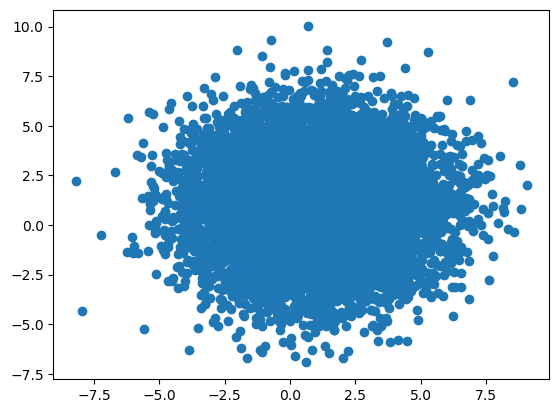

In [8]:
n = 10000  # number of samples (descrease the number if computations take too much time)
mu, sigma = np.ones(2), 5 * np.eye(2)  # mean and standard deviation of ground truth distribution
data = np.random.multivariate_normal(mu, sigma, n)  # sample n data points from the distribution

# Cast those into torch's tensors so everything works well
mu = torch.from_numpy(mu)
sigma = torch.from_numpy(sigma)
data = torch.from_numpy(data)

plt.scatter(data[:, 0], data[:, 1])
plt.show()

NUM_OF_STEPS = 1000
CONVERGENCE_THRESHOLD = 0.01

# Praxis - task 1

In [10]:
def task_1_function(X, sigma, num_of_steps, learning_rate, convergence_threshold):
    mu = torch.tensor((0., 0.), requires_grad=True)
    mu_history = [mu.detach().clone()]
    previous_loss = float("inf")  # set it to infinity, so we do not reach convergence at the very first step

    for i in range(num_of_steps):
        loss = L(X, mu, sigma)
        loss.backward()
        mu.data = mu.data + learning_rate * mu.grad
        mu.grad.zero_()

        mu_history.append(mu.detach().clone())

        if abs(loss.data - previous_loss) <= convergence_threshold:
            print(f"Convergence reached at step={i}")
            break
        previous_loss = loss.data

    vizualize(data, mu_history, sigma)

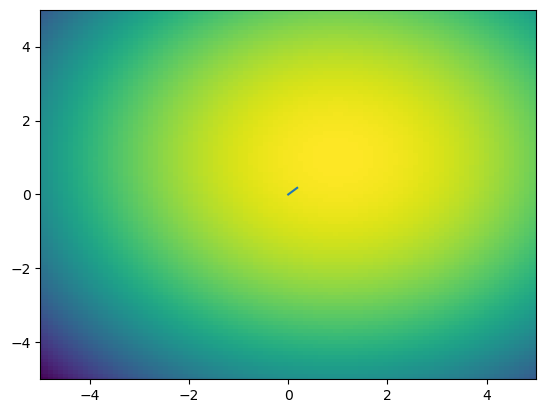

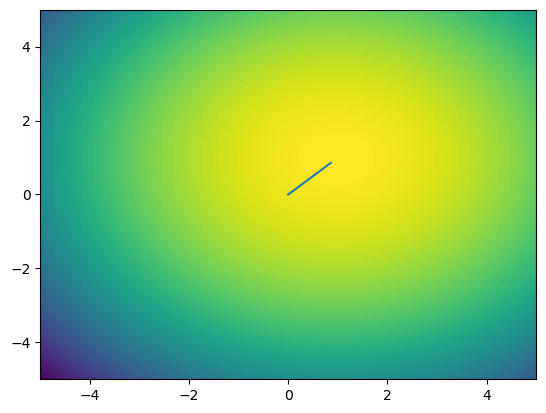

Convergence reached at step=223


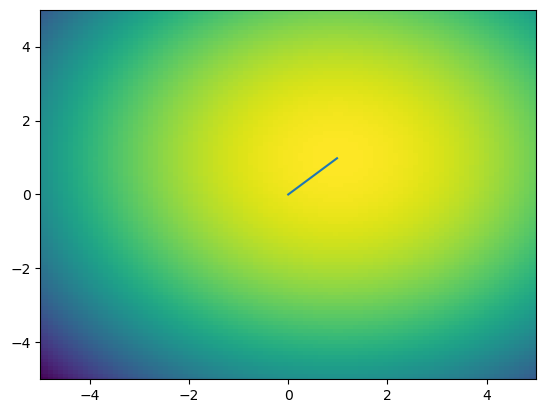

Convergence reached at step=27


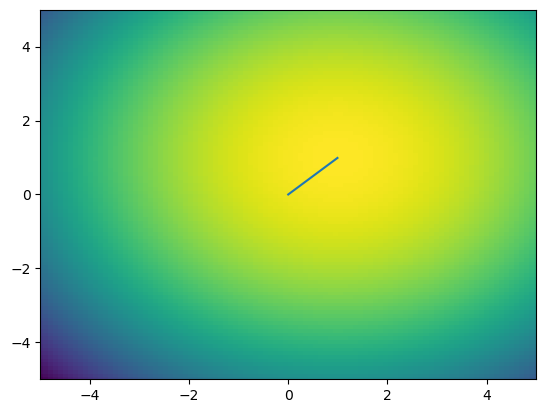

In [11]:
for lr in [1e-7, 1e-6, 1e-5, 1e-4]:
    task_1_function(data, sigma, NUM_OF_STEPS, lr, CONVERGENCE_THRESHOLD)

## Task1 - answer
As the lambda/learning_rate get bigger, our algorithm moves faster towards minimum
- `1e-7` - we didn't reach minimum
- `1e-6` - we also didn't reach minimum. We finished much closer
- `1e-5` - we reached convergence in 223 steps
- `1e-4` - we reached convergence in 27 steps

# Praxis - task 2

In [13]:
def task_2_function(X, sigma, num_of_steps, learning_rate, convergence_threshold):
    mu = torch.tensor((0., 0.), requires_grad=True)
    mu_history = [mu.detach().clone()]
    previous_loss = float("inf")  # set it to infinity, so we do not reach convergence at the very first step

    optimizer = torch.optim.Adam(params=[mu], lr=learning_rate)
    for i in range(num_of_steps):
        loss = -L(X, mu, sigma)  # NOTE: we calculate "-L" because we want to perform gradient ASCENT instead of descent!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mu_history.append(mu.detach().clone())

        if abs(loss.data - previous_loss) <= convergence_threshold:
            print(f"Convergence reached at step={i}")
            break
        previous_loss = loss.data

    vizualize(data, mu_history, sigma)

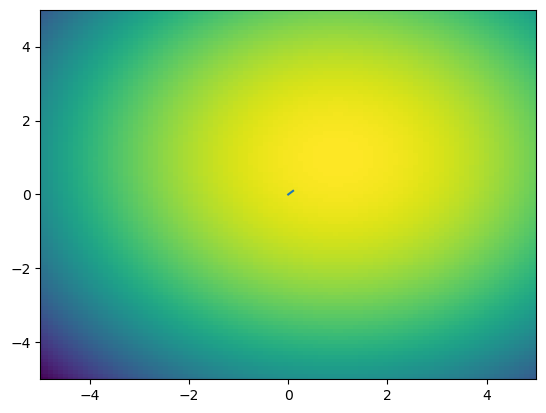

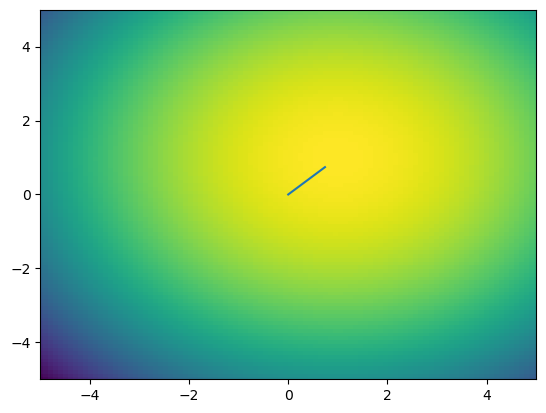

Convergence reached at step=444


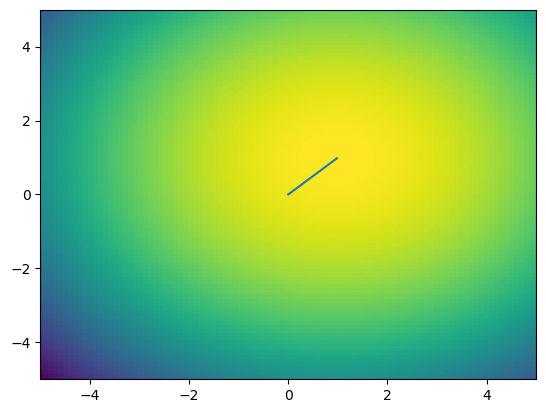

Convergence reached at step=217


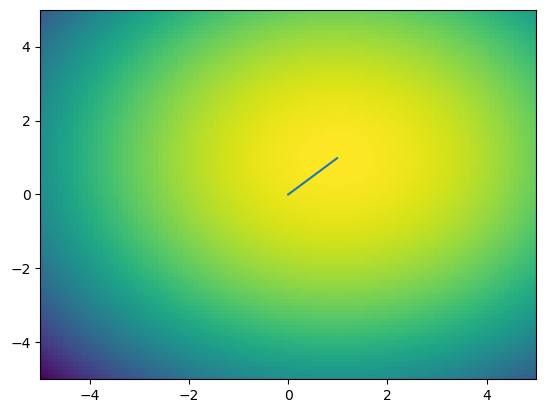

In [15]:
for lr in [1e-4, 1e-3, 5e-3, 1e-2]:
    task_2_function(data, sigma, NUM_OF_STEPS, lr, CONVERGENCE_THRESHOLD)

## Task2 - answer
TODO

# Praxis - task 3

In [19]:
def task_3_function(X, sigma, num_of_steps, learning_rate, convergence_threshold, number_of_samples):
    mu = torch.tensor((0., 0.), requires_grad=True)
    mu_history = [mu.detach().clone()]
    # previous_loss = float("inf")  # set it to infinity, so we do not reach convergence at the very first step

    optimizer = torch.optim.Adam(params=[mu], lr=learning_rate)
    for i in range(num_of_steps):
        # draw which data points will be taken into batch
        indices = np.random.choice(len(X), size=number_of_samples, replace=False)
        samples = X[indices]

        loss = -L(samples, mu, sigma)  # NOTE: we calculate "-L" because we want to perform gradient ASCENT instead of descent!
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        mu_history.append(mu.detach().clone())

        # if abs(loss.data - previous_loss) <= convergence_threshold:
        #     print(f"Convergence reached at step={i}")
        #     break
        # previous_loss = loss.data

    vizualize(data, mu_history, sigma)

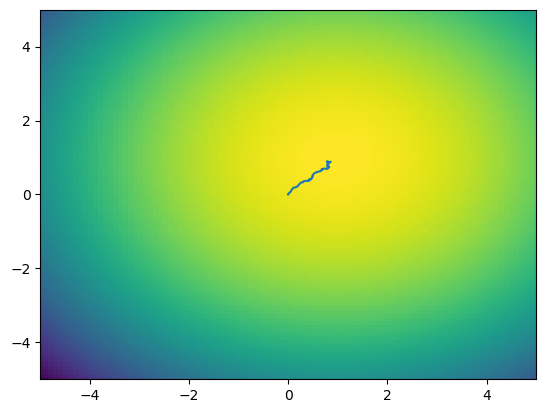

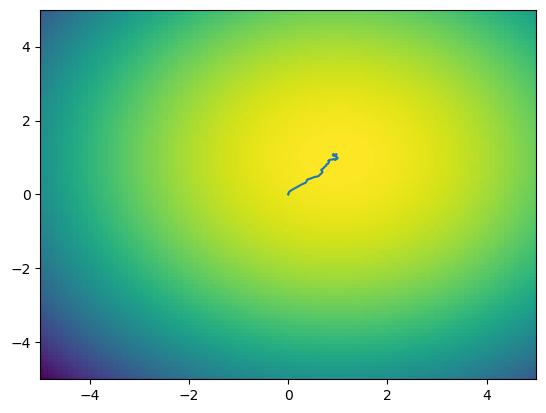

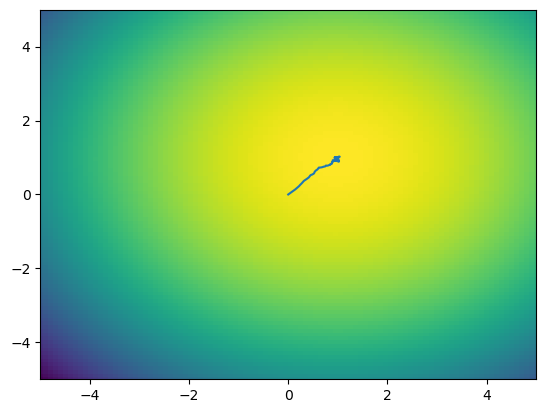

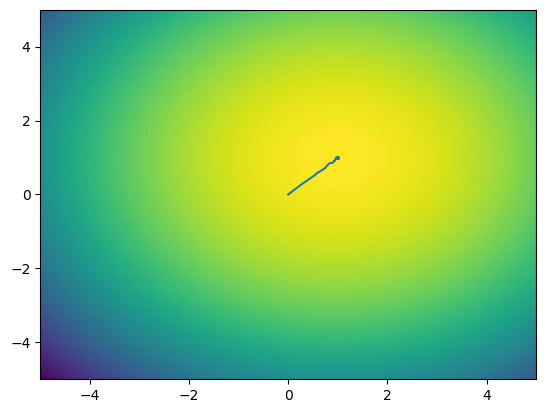

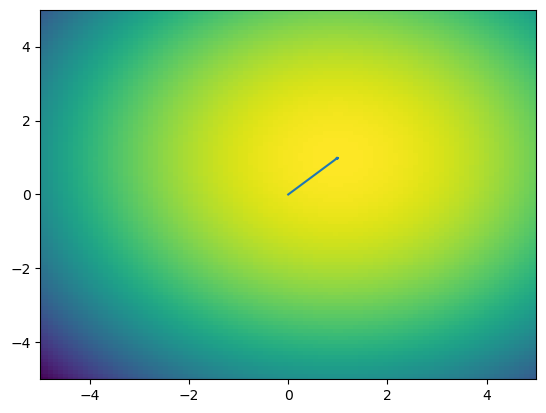

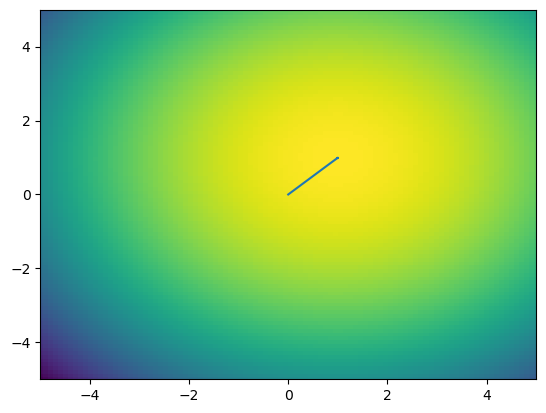

In [20]:
for k in [1, 5, 10, 100, 1000, 5000]:
    task_3_function(data, sigma, NUM_OF_STEPS, 5e-3, CONVERGENCE_THRESHOLD, k)

## Task3 - answer
TODO